#**AUTORES**: 
### **Carlos Ramos Mateos**
### **Adrián Rubio Pintado**

# GridWorld 2:

*GridWorld* es un mundo en forma de cuadrícula muy utilizado como entorno de pruebas para técnicas de Aprendizaje por Refuerzo. Dentro de esta cuadrícula hay varios tipos de celdas: iniciales, libres, obstáculos, terminales... ¡y ahora también agujeros de gusano! Los agentes tienen que llegar desde una celda inicial hasta otra terminal evitando los obtáculos y recorriendo una distancia mínima.

Paquetes necesarios para *GridWorld 2*:

In [1]:
import numpy as np
import math

Funciones auxiliares para visualizar información:

In [2]:
def printMap(world):
  # Visualiza el mapa de GridWorld
  m = "["
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      if world.map[(i, j)] == 0: 
        m += " O "
      elif world.map[(i, j)] == -1:
        m += " X " 
      elif world.map[(i, j)] == 1:
        m += " F "
      elif world.map[(i, j)] == 2:
        m += " T "
    if i == world.size[0] - 1:
      m += "]\n"
    else:
      m += "\n"
  print(m)

def printPolicy(world, policy):
  # Visualiza la política con flechas
  p = "["
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      if policy[i][j] == 0:
        p += " ^ "
      elif policy[i][j] == 1:
        p += " V "
      elif policy[i][j] == 2:
        p += " < "
      else:
        p += " > "
    if i == world.size[0] - 1:
      p += "]\n" 
    else:
      p += "\n"
  print(p)

# Clase *World*: 

Esta clase almacena la información del mundo:

*   *Map*: Matriz con la codificación del mundo con celdas libres (0), obstáculos (-1) y terminales (1)
*   *Size*: Vector con el tamaño de la matriz de codificación del mundo (ancho, alto)

Para crear un mundo hay que aportar los siguientes datos:

*   Tamaño del mapa (ancho, alto)
*   Lista de celdas terminales
*   Lista de celdas con obstáculos
*   Agujero de gusano

Notas:

* Cuando el agente cae en un obstáculo se queda atrapado para siempre en él
* Cuando el agente entra por un extremo del agujero de gusano sale por el otro extremo

Por ejemplo: 

w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])

Crea un mundo de 10 filas y 10 columnas con un estado terminal (9, 9), dos obstáculos en (2, 4) y (4, 2) y un teletransporte entre (0, 2) y (9, 7).

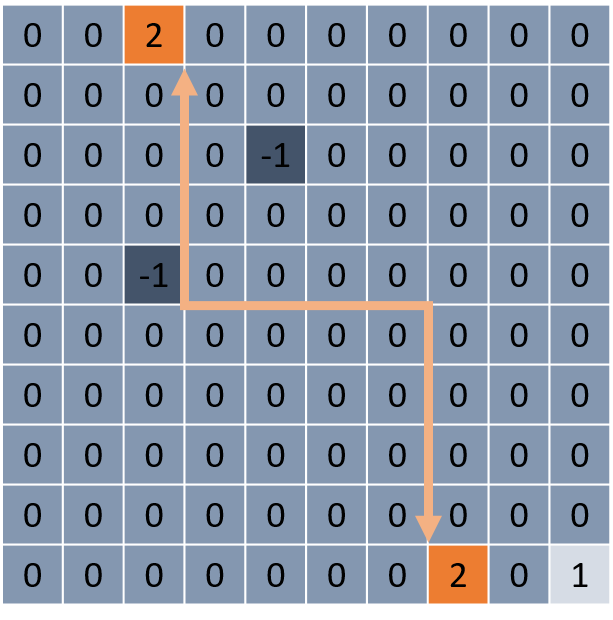

In [3]:
class World:

  def __init__(self, size, terminal, obstacle, hole):
    # Crea un mundo
    self.size = size
    self.map = {}
    for i in range(size[0]):
      for j in range(size[1]):
        # Estados libres
        self.map[(i, j)] = 0
        # Estados terminales
        for t in terminal:
          if i==t[0] and j==t[1]:
            self.map[(i, j)] = 1
        # Estados con obstáculos
        for o in obstacle:
          if i==o[0] and j==o[1]:
            self.map[(i, j)] = -1
        for h in hole:
          if i==h[0] and j==h[1]:
            self.map[(i, j)] = 2

Prueba de la clase *World*:

In [4]:
if __name__ == "__main__":
  w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])
  printMap(w)

[ O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F ]



# Clase *Agent*:

Esta clase controla el agente que aprende por refuerzo en *GridWorld*. 

Para crear un agente se necesitan los siguientes datos:

*   *World*: Mundo en el que se desenvuelve el agente.
*   *Initial State*: Estado inicial del agente.

Para controlar el agente se usan los siguientes métodos:

*   *nextState = move(state, action)*: Mueve el agente del estado *state* a un nuevo estado *nextState* aplicando una acción *action*.
*   *reward = reward(nextState)*: Devuelve el refuerzo *reward* que recibe el agente al transicionar al estado *nextState*.
*   *nextState, reward = checkAction(state, action)*: Comprueba a qué estado *nextState* y con qué refuerzo *reward* cambia el agente al aplicar la acción *action* en el estado *state*. Este método no cambia el estado interno del agente, por lo que puede usarse para hacer barridos del espacio de estados.
*   *nextState, reward = executeAction(action)*: Ejecuta la acción *action* en el estado actual y devuelve el nuevo estado *nextState* y el refuerzo *reward*. Este método cambia el estado interno del agente, por lo que sólo debe usarse cuando se realice un recorrido por el mundo.

Nota: Podéis hacer cambios en el agente (distribución de refuerzos, comportamiento en obstáculos...) buscando mejorar el rendimiento de los algoritmos. 

Cambiamos el valor de los refuerzos,**añadiendo refuerzo al salirse del mapa, editando el código del agente para ello.**

In [11]:
import sys

#FLAGS
REWARD_OBSTACLE = -100
REWARD_TERMINAL = sys.maxsize
REWARD_NEWCELL = -1
REWARD_OUTOFMAP = -15

Observamos que con refuerzos negativos cada vez que avanza una celda obtenemos mejores resultados:convergen antes los algoritmos en menos épocas. Además hemos añadido una recompensa negativa si intenta salirse del mapa, que de nuevo, facilita la convergencia también.

El reward negativo para los obstáculos lo situamos a un valor tan alto, ya que dado que el agente se queda atrapado en ellos una vez ha caído en ellos, debemos penalizar mucho este comportamiento para que evite los obstáculos a toda costa.

El reward del estado terminal lo hemos puesto a un número muy grande, debido a que en función de la longtud necesaria para resolver laberintos grandes, este refuerzo positivo atraiga de una manera muy fuerte al agente.

In [6]:
from numpy.lib.type_check import real
class Agent:

  def __init__(self, world, initialState):
    # Crea un agente
    self.world = world
    self.state = np.array(initialState)
    
  def set_initialState(self,initialState):
    self.state = np.array(initialState)

  def move(self, state, action):
    # Gestiona las transiciones de estados
    nextState = state + np.array(action)
    if nextState[0] < 0:
      nextState[0] = 0
    elif nextState[0] >= self.world.size[0]:
      nextState[0] = self.world.size[0] - 1
    if nextState[1] < 0:
      nextState[1] = 0
    elif nextState[1] >= self.world.size[1]:
      nextState[1] = self.world.size[1] - 1
    if self.world.map[(nextState[0], nextState[1])] == 2:
      aux = nextState
      for i in range(self.world.size[0]):
        for j in range(self.world.size[1]):
          if self.world.map[(i, j)] == 2 and (nextState[0] != i and nextState[1] != j):
            aux = np.array([i, j])
            nextState = aux
    return nextState

  def reward(self, nextState):
    # Gestiona los refuerzos
    if self.world.map[(nextState[0], nextState[1])] == -1:
      # Refuerzo cuando el agente intenta moverse a un obstáculo
      reward = REWARD_OBSTACLE # ** Prueba varios valores **
    elif self.world.map[(nextState[0], nextState[1])] == 1:
      # Refuerzo cuando el agente se mueve a una celda terminal
      reward = REWARD_TERMINAL # ** Prueba varios valores **
    else:
      # Refuerzo cuando el agente se mueve a una celda libre
      reward = REWARD_NEWCELL # ** Prueba varios valores ** 
    return reward

  def move_and_reward(self, state, action):


    #Estoy en un  Obstaculo      
    if self.world.map[(self.state[0], self.state[1])] == -1: 
      nextState = self.state     
      reward = REWARD_OBSTACLE
      return nextState,reward


    # Gestiona las transiciones de estados
    nextState = state + np.array(action)
    reward = np.nan

    #Fuera del mapa
    if nextState[0] < 0:
      nextState[0] = 0
      reward = REWARD_OUTOFMAP
    elif nextState[0] >= self.world.size[0]:
      nextState[0] = self.world.size[0] - 1
      reward = REWARD_OUTOFMAP

    if nextState[1] < 0:
      nextState[1] = 0
      reward = REWARD_OUTOFMAP
    elif nextState[1] >= self.world.size[1]:
      nextState[1] = self.world.size[1] - 1
      reward = REWARD_OUTOFMAP

    #Agujero de gusano
    if self.world.map[(nextState[0], nextState[1])] == 2:
      aux = nextState
      for i in range(self.world.size[0]):
        for j in range(self.world.size[1]):
          if self.world.map[(i, j)] == 2 and (nextState[0] != i and nextState[1] != j):
            aux = np.array([i, j])
            nextState = aux

  


    if(np.isnan(reward) ):
      reward = self.reward(nextState)

    return nextState,reward

  def checkAction(self, state, action):
    # Planifica una acción
    nextState = self.move(state, action)
    if self.world.map[(state[0], state[1])] == -1: 
      nextState = state                            
    reward = self.reward(nextState)
    return nextState, reward

  def executeAction(self, action):
    # Planifica y ejecuta una acción
    #nextState = self.move(self.state, action)
    nextState,reward = self.move_and_reward(self.state, action)
    self.state = nextState 
    #reward = self.reward(nextState)
    return self.state, reward  

Prueba de la clase *Agent*:

In [7]:
if __name__ == "__main__":
  # Crear el mundo
  w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])
  printMap(w)
  # Crear el agente
  a = Agent(w, (0, 0))
  # Mover el agente en la diagonal principal
  for i in range(1, 5):
    # Mostrar cada nuevo estado y su recompensa
    print(a.executeAction((0, 1)))

[ O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F ]

(array([0, 1]), 0)
(array([9, 7]), 0)
(array([9, 8]), 0)
(array([9, 9]), 9223372036854775807)


# Trabajo:

En este trabajo vais a implementar los dos algoritmos más comunes de aprendizaje por refuerzo basados en el valor: SARSA y QLearning. Además, vais a probar ambos algoritmos en una serie de escenarios para evaluar su funcionamiento y comparar sus resultados.

## Mundos: 

Para probar los algoritmos se ofrecen los siguientes mundos en varios tamaños:

*   Mundo 1: Laberinto fácil que se puede recorrer en zigzag
*   Mundo 2: Mundo con obstáculos aleatorios en el que el teletransporte acorta la distancia desde el inicio hasta el final
*   Mundo 3: Mundo con obstáculos aleatorios en el que el teletransporte no reduce la distancia desde el inicio hasta el final
*   Mundo 4: Laberinto difícil con caminos correctos y equivocados

Nota: Sentíos libres de utilizar todos o algunos de estos escenarios o directamente crear vuestros propios escenarios.

In [8]:
if __name__ == "__main__":
  
  # Mundo 1 pequeño: Laberinto fácil
  obstacles = []
  for j in range(0, 4):
    obstacles.append((j, 1))
  for j in range(1, 5):
    obstacles.append((j, 3))
  w1p = World((5, 5), [(4, 4)], obstacles, [])
  print("World 1: ")
  printMap(w1p)

  # Mundo 1 mediano: Laberinto fácil
  obstacles = []
  for i in [1, 5]:
    for j in range(0, 8):
      obstacles.append((j, i))
  for i in [3, 7]:
    for j in range(1, 9):
      obstacles.append((j, i))
  w1m = World((9, 9), [(8, 8)], obstacles, [])
  print("World 1: ")
  printMap(w1m)

  # Mundo 1 grande: Laberinto fácil
  obstacles = []
  for i in [1, 5, 9, 13, 17]:
    for j in range(0, 20):
      obstacles.append((j, i))
  for i in [3, 7, 11, 15, 19]:
    for j in range(1, 21):
      obstacles.append((j, i))
  w1g = World((21, 21), [(20, 20)], obstacles, [])
  print("World 1: ")
  printMap(w1g)

  # Mundo 2 pequeño: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))  
  w2p = World((5, 5), [(4, 4)], obstacles, [(2, 0), (4, 2)])
  print("World 2: ")
  printMap(w2p)

  # Mundo 2 mediano: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))  
  w2m = World((10, 10), [(9, 9)], obstacles, [(3, 1), (8, 6)])
  print("World 2: ")
  printMap(w2m)

  # Mundo 2 grande: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))  
  w2g = World((21, 21), [(20, 20)], obstacles, [(6, 2), (18, 14)])
  print("World 2: ")
  printMap(w2g)

  # Mundo 3 pequeño: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))  
  w3p = World((5, 5), [(4, 4)], obstacles, [(4, 0), (0, 4)])
  print("World 3: ")
  printMap(w3p)

  # Mundo 3 mediano: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))  
  w3m = World((10, 10), [(9, 9)], obstacles, [(8, 1), (1, 8)])
  print("World 3: ")
  printMap(w3m)

  # Mundo 3 grande: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))  
  w3g = World((21, 21), [(20, 20)], obstacles, [(18, 2), (2, 18)])
  print("World 3: ")
  printMap(w3g)

  # Mundo 4: Laberinto difícil
  obstacles = [(0,1),(0,3),(0,9),(0,15),(0,16),(0,17),(0,19),
               (1,1),(1,3),(1,4),(1,5),(1,6),(1,7),(1,9),(1,10),(1,11),(1,12),(1,13),(1,17),(1,19),
               (2,1),(2,9),(2,13),(2,15),(2,16),(2,17),(2,19),
               (3,1),(3,3),(3,5),(3,7),(3,9),(3,11),(3,16),(3,19),
               (4,3),(4,5),(4,7),(4,8),(4,9),(4,10),(4,11),(4,12),(4,13),(4,14),(4,16),(4,18),(4,19),
               (5,0),(5,1),(5,2),(5,3),(5,5),(5,9),(5,16),
               (6,5),(6,6),(6,7),(6,9),(6,10),(6,11),(6,12),(6,13),(6,14),(6,16),(6,17),(6,19),
               (7,0),(7,1),(7,2),(7,3),(7,5),(7,7),(7,9),(7,19),
               (8,3),(8,7),(8,8),(8,9),(8,12),(8,13),(8,14),(8,15),(8,16),(8,17),(8,18),(8,19),
               (9,1),(9,3),(9,5),(9,7),(9,11),(9,12),(9,19),(9,20),
               (10,1),(10,3),(10,5),(10,6),(10,7),(10,9),(10,11),(10,14),(10,15),(10,16),(10,17),
               (11,1),(11,3),(11,5),(11,9),(11,11),(11,13),(11,14),(11,17),(11,18),(11,19),
               (12,1),(12,5),(12,6),(12,8),(12,9),(12,11),(12,13),(12,19),
               (13,1),(13,2),(13,3),(13,4),(13,5),(13,8),(13,15),(13,16),(13,17),(13,19),
               (14,4),(14,7),(14,8),(14,10),(14,12),(14,13),(14,15),(14,19),
               (15,0),(15,1),(15,2),(15,6),(15,7),(15,10),(15,13),(15,14),(15,15),(15,17),(15,18),(15,19),(15,20),
               (16,2),(16,3),(16,5),(16,6),(16,7),(16,8),(16,9),(16,10),(16,11),(16,15),(16,17),
               (17,0),(17,3),(17,5),(17,9),(17,13),(17,14),(17,15),(17,17),(17,19),
               (18,0),(18,1),(18,5),(18,6),(18,7),(18,9),(18,10),(18,11),(18,15),(18,19),
               (19,1),(19,2),(19,4),(19,5),(19,11),(19,13),(19,14),(19,15),(19,16),(19,17),(19,18),(19,19),
               (20,7),(20,8),(20,9),(20,11),(20,19)]          
  print("World 4: ")
  w4 = World((21, 21), [(20, 20)], obstacles, [])
  printMap(w4)

World 1: 
[ O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

World 1: 
[ O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

World 1: 
[ O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  

## SARSA:

*SARSA* (State-Action-Reward-State-Action) es un método basado en el valor que permite resolver problemas de aprendizaje por refuerzo. Al igual que el resto de métodos basados en el valor, *SARSA* calcula de forma iterativa la función de valor $Q(S,A)$ y, a partir de ella, determina la política óptima $\pi$.

*SARSA* recibe su nombre de las cinco variables implicadas en su función de actualización: el estado actual ($S_t$), la acción actual ($A_t$), el refuerzo actual ($R_t$), el siguiente estado ($S_{t+1}$) y la siguiente acción ($A_{t+1}$). Esta función de actualización tiene la siguiente forma:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t,A_t)]
\end{equation}

Nota: $\alpha$ es la longitud del episodio y $\gamma$ el factor de descuento.

El algoritmo *SARSA* sigue el siguiente esquema: 

1.   Inicializar $Q(S,A)$ para todos los estados y acciones 
2.   **Bucle** (repetir $3-9$ hasta la convergencia):
3.   Inicializar $S_t$
4.   Elegir $A_t$ en $S_t$ siguiendo la política derivada de $Q(S,A)$
5.   **Bucle** (repetir $6-9$ hasta que $S_t$ sea terminal):
6.   Tomar la acción $A_t$ en $S_t$ y observar $R_t$ y $S_{t+1}$
7.   Elegir $A_{t+1}$ en $S_{t+1}$ siguiendo la política derivada de $Q(S,A)$
8.   Actualizar el valor $Q(S_t, A_t)$ con la función de actualización
9.   Tomar $S_{t+1}$ y $A_{t+1}$ como los nuevos $S_t$ y $A_t$

El algoritmo *SARSA* utiliza un parámetro $\epsilon \in (0, 1)$ para buscar un equilibrio entre exploración y explotación. A la hora de elegir $A_t$ en $S_t$, si un número aleatorio es menor que $\epsilon$, el algoritmo tomará una acción aleatoria; mientras que si ese número aleatorio es mayor que $\epsilon$, el algoritmo tomará la mejor acción conocida.

## Ejercicio 1:

Implementad el algoritmo SARSA para el agente y entorno definidos anteriormente.

In [12]:
ACTIONS = [(0,1), (0,-1) , (1,0), (-1,0)]
DICCIONARIO = {(0,1):'Derecha' , (0,-1): 'Izquierda' , (1,0) :'Abajo', (-1,0):'Arriba'}

In [14]:
import random

def choose_max_Q(S, Q):

  
  actions_S = [  ( A, Q[(S,A)]) for A in ACTIONS  ]
  max_value = max(actions_S, key = lambda x: x[1])[1]
  possible_actions = [A[0] for A in actions_S if A[1] == max_value]
  return random.choice(possible_actions)


def elige_accion(epsilon,Q, S):
  rand_num = np.random.rand(1)[0]
  if(rand_num <= epsilon):
    return random.choice(ACTIONS)
  else:   
    return choose_max_Q(S, Q)

def sarsa(agent,init_state = (0,0), alpha = 0.5,gamma = 0.9 , epsilon = 0.1 , max_iterations =10000, debug = False):

  assert alpha >= 0 and alpha <= 1, 'Alpha debe de estar entre 0 y 1'
  assert gamma >= 0 and gamma <= 1, 'Gamma debe de estar entre 0 y 1'

  size = agent.world.size

  #Incializando valores
  Q = {}
  for i in range(size[0]):
    for j in range(size[1]):
      Q.update(  { ((i,j),a):(0 if agent.world.map[(i,j)] == 1 else -1)  for a in ACTIONS})#estados terminales nulos, el resto arbitrario (a 1)
      #Q.update(  { ((i,j),a):0. for a in ACTIONS})#estados terminales nulos


  sum_rewards_per_episode = []
  #Eleccion de acción de acuerdo a Q(S,A)
  for i in range(max_iterations): #bucle convergencia
    S = init_state
    A = elige_accion(epsilon,Q, S)
    agent.set_initialState(init_state)
    if(debug): print('Iteración:', i+1)
    sum_rewards_per_episode.append(0)
    #counter_hole = 0
    
    while(agent.world.map[S] != 1): #S terminal
      S_prima,R = agent.executeAction(A)
      S_prima = (S_prima[0], S_prima[1])
      A_prima = elige_accion(epsilon,Q, S_prima)
      sum_rewards_per_episode[i] = sum_rewards_per_episode[i] + R
      #Update model
      Q[(S,A)] = Q[(S,A)] + alpha*( R + ( gamma*Q[(S_prima,A_prima)] ) - Q[(S,A)] )

      # indica que ha caído en obstaculo, y no puede moverse más
      if (agent.world.map[S_prima] == -1):
        break
       
      S = S_prima
      A = A_prima


  return Q,sum_rewards_per_episode



**Definimos una función para movernos:**

Siguiendo las política basada en valores obtenida con SARSA/Q-Learning.

In [15]:

def move_with_value_function(agent, Q, init_state = (0,0), verbosse = True, max_steps = 999999):
  '''
    Returns:
      number of steps walked
  '''

  S = init_state
  agent.set_initialState(S)

  A = choose_max_Q(S, Q)
  if(verbosse): print('Initial S:', S, '--(A:', A,DICCIONARIO[A],') -->')
  #print('Init action', A)

  # Mostrar cada nuevo estado y su recompensa
  i = 0 
  while(agent.world.map[S] != 1): #Hasta estado terminal, sigue moviendose
    S, R =agent.executeAction(A)
    S = (S[0], S[1])
    A = choose_max_Q(S, Q)
    if(verbosse): print('Now in S:',S, '--(A:', A,DICCIONARIO[A], ') -->')
    if( agent.world.map[(S[0], S[1])] == -1):
      print('\tTRAPPED IN OBSTACLE!!!')
      break;
    i = i+1
    if(i>max_steps):break
  print('END: ', i , 'steps.')
  return i

Ejecutamos un minitest:

In [152]:
w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])
a = Agent(w, (0, 0))
#Q_test = sarsa(a,debug = True)
Q_test = sarsa(a)

In [47]:
a.set_initialState((0, 0))
Q_final = move_with_value_function(a ,Q_test)

Initial S: (0, 0) --(A: (0, 1) Derecha ) -->
Now in S: (0, 1) --(A: (0, 1) Derecha ) -->
Now in S: (9, 7) --(A: (0, 1) Derecha ) -->
Now in S: (9, 8) --(A: (0, 1) Derecha ) -->
Now in S: (9, 9) --(A: (0, 1) Derecha ) -->
END


## **Q-Learning:**

*Q-Learning* es el método más conocido para resolver problemas de aprendizaje por refuerzo mediante un esquema basado en el valor. Este algoritmo recibe su nombre directamente de $Q(S,A)$, la función de valor que va actualizando a lo largo de su ejecución. *Q-Learning* es muy parecido a *SARSA*, pero tiene una función de actualización diferente:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma max_a{Q(S_{t+1}}, a) - Q(S_t,A_t)]
\end{equation}

En este caso, la acción $A_{t+1}$ en $S_{t+1}$ se toma buscando el máximo valor, en lugar de poder elegir entre exploración o explotación.

El algoritmo *Q-Learning* sigue el siguiente esquema: 

1.   Inicializar $Q(S,A)$ para todos los estados y acciones 
2.   **Bucle** (repetir $3-8$ hasta la convergencia):
3.   Inicializar $S_t$
4.   **Bucle** (repetir $6-8$ hasta que $S_t$ sea terminal):
5.   Elegir $A_t$ en $S_t$ siguiendo la política derivada de $Q(S,A)$
6.   Tomar la acción $A_t$ en $S_t$ y observar $R_t$ y $S_{t+1}$
7.   Actualizar el valor $Q(S_t, A_t)$ con la función de actualización
8.   Tomar $S_{t+1}$ como el nuevo $S_t$

## Ejercicio 2:
Implementad el algoritmo Q-Learning para el agente y entorno definidos anteriormente.


In [20]:
import random



def choose_max_Q(S, Q):

  
  actions_S = [  ( A, Q[(S,A)]) for A in ACTIONS  ]
  max_value = max(actions_S, key = lambda x: x[1])[1]
  possible_actions = [A[0] for A in actions_S if A[1] == max_value]
  return random.choice(possible_actions)

  

def elige_accion(epsilon,Q, S):
  rand_num = np.random.rand(1)[0]
  if(rand_num <= epsilon):
    return random.choice(ACTIONS)
  else:   
    return choose_max_Q(S, Q)

def qlearning(agent,init_state = (0,0), alpha = 0.5,gamma = 0.9,  epsilon = 0.1  , max_iterations =10000, debug = False):

  assert alpha >= 0 and alpha <= 1, 'Alpha debe de estar entre 0 y 1'
  assert gamma >= 0 and gamma <= 1, 'Gamma debe de estar entre 0 y 1'

  size = agent.world.size

  #Incializando valores
  Q = {}
  for i in range(size[0]):
    for j in range(size[1]):
      Q.update(  { ((i,j),a):(0 if agent.world.map[(i,j)] == 1 else -1)  for a in ACTIONS})#estados terminales nulos, el resto arbitrario (a 1)
      #Q.update(  { ((i,j),a):0. for a in ACTIONS})#estados terminales nulos


  sum_rewards_per_episode = []
  #Eleccion de acción de acuerdo a Q(S,A)
  for i in range(max_iterations): #bucle convergencia
    S = init_state
    agent.set_initialState(init_state)
    sum_rewards_per_episode.append(0)
    if(debug): print('Iteración:', i+1)

    
    while(agent.world.map[S] != 1): #S terminal
      A = elige_accion(epsilon,Q, S)
      S_prima,R = agent.executeAction(A)
      S_prima = (S_prima[0], S_prima[1])
      sum_rewards_per_episode[i] = sum_rewards_per_episode[i] + R

    
      #Update model
      Q[(S,A)] = Q[(S,A)] + alpha*( R + ( gamma*Q[(S_prima,choose_max_Q(S_prima, Q))] ) - Q[(S,A)] )

      #if(R == REWARD_OBSTACLE):#R = -1 indica que ha caído en obstaculo, y no puede moverse más
      if (agent.world.map[S_prima] == -1):
        break

      S = S_prima


  return Q,sum_rewards_per_episode


## Comparativa 

Hacemos una comparativa con una selección de los mundos para ver si ambos algorimos son capaces de resolver los laberintos.

Creamos una función para **comparar los rendimientos como la suma del numero de rewards por episodio frente al numero de episodios.**

Incluimos una **opción de promediar cada mean_each_n episodios**, para evitar picos dado el valor tan alto de refuerzos que hemos elegido.

Incluimos también la opción de graficar lo anterior **de manera acumulada**, de modo que vaya sumando las rewards de cada episodio de manera acumulada, con el objetivo de **estudiar la convergencia** de los algoritmos para los ejemplos.

In [33]:
import plotly.graph_objects as go

def plot_performance(rewards_sarsa, rewards_ql, size = None, mean_each_n = None,acumulated = False):

  if(size is None):
    r_sarsa = rewards_sarsa
    r_ql = rewards_ql
  else:
    r_sarsa = rewards_sarsa[0:size]
    r_ql = rewards_ql[0:size]

  if(mean_each_n is not None): #Media cada n elementos, para evitar picos
    r_sarsa = np.array(r_sarsa)
    r_ql = np.array(r_ql)

    r_sarsa = np.average(r_sarsa.reshape(-1, mean_each_n), axis=1).tolist() 
    r_ql = np.average(r_ql.reshape(-1, mean_each_n), axis=1).tolist() 

    r_sarsa = [i/mean_each_n for i in r_sarsa ]
    r_ql = [i/mean_each_n for i in r_sarsa ]
    title = 'Sum of reward for each episode(averaged with each ' + str(mean_each_n) + ' episodes)'
    x_title = 'Number of episodes(averaged with each ' + str(mean_each_n) + ' episodes)'
  else:
    title = 'Sum of reward for each episode'
    x_title = 'Number of episodes'


  if(acumulated):
    title = title + ' ACUMULATED'
    r_sarsa = np.cumsum(r_sarsa).tolist()
    r_ql = np.cumsum(r_ql).tolist()
  
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=[i for i  in  range(len(r_sarsa))], y=r_sarsa,
                    mode='lines+markers',
                    name='SARSA'))
  fig.add_trace(go.Scatter(x=[i for i  in  range(len(r_ql))], y=r_ql,
                    mode='lines+markers',
                    name='Q-Learning'))

  

  fig.update_layout(
    title=title,
    xaxis_title=x_title,
    yaxis_title="Sum of rewards during episode",
    legend_title="Legend Title",
    font=dict(
        family="Courier New, monospace",
        color="RebeccaPurple"
      )
    )

  fig.show()

Procedemos ahora a resolver varios laberintos, escogiendo aquellos que nos parecían más relvante y representativos para estudiar los algoritmos.

### World1p

In [17]:
printMap(w1p)

[ O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]



#### SARSA

In [18]:
#SARSA
agent_w1p_sarsa = Agent(w1p, (0, 0))
Q_w1p_sarsa, rewards_w1p_sarsa = sarsa(agent_w1p_sarsa,init_state = (0,0), alpha = 0.5,gamma = 0.9 , epsilon = 0.1 , max_iterations =10000, debug = False)
move_with_value_function(agent_w1p_sarsa,Q_w1p_sarsa, max_steps = 50)

Initial S: (0, 0) --(A: (1, 0) Abajo ) -->
Now in S: (1, 0) --(A: (1, 0) Abajo ) -->
Now in S: (2, 0) --(A: (1, 0) Abajo ) -->
Now in S: (3, 0) --(A: (1, 0) Abajo ) -->
Now in S: (4, 0) --(A: (0, 1) Derecha ) -->
Now in S: (4, 1) --(A: (0, 1) Derecha ) -->
Now in S: (4, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (3, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (2, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (1, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (0, 2) --(A: (0, 1) Derecha ) -->
Now in S: (0, 3) --(A: (0, 1) Derecha ) -->
Now in S: (0, 4) --(A: (1, 0) Abajo ) -->
Now in S: (1, 4) --(A: (1, 0) Abajo ) -->
Now in S: (2, 4) --(A: (1, 0) Abajo ) -->
Now in S: (3, 4) --(A: (1, 0) Abajo ) -->
Now in S: (4, 4) --(A: (-1, 0) Arriba ) -->
END:  16 steps.


16

####Q-LEARNING

In [22]:
#Q-LEARNING
agent_w1p_ql = Agent(w1p, (0, 0))
Q_w1p_ql, rewards_w1p_ql = qlearning(agent_w1p_ql,init_state = (0,0), alpha = 0.5,gamma = 0.9,  epsilon = 0.1  , max_iterations =10000, debug = False)
move_with_value_function(agent_w1p_ql,Q_w1p_ql, max_steps = 50)

Initial S: (0, 0) --(A: (1, 0) Abajo ) -->
Now in S: (1, 0) --(A: (1, 0) Abajo ) -->
Now in S: (2, 0) --(A: (1, 0) Abajo ) -->
Now in S: (3, 0) --(A: (1, 0) Abajo ) -->
Now in S: (4, 0) --(A: (0, 1) Derecha ) -->
Now in S: (4, 1) --(A: (0, 1) Derecha ) -->
Now in S: (4, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (3, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (2, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (1, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (0, 2) --(A: (0, 1) Derecha ) -->
Now in S: (0, 3) --(A: (0, 1) Derecha ) -->
Now in S: (0, 4) --(A: (1, 0) Abajo ) -->
Now in S: (1, 4) --(A: (1, 0) Abajo ) -->
Now in S: (2, 4) --(A: (1, 0) Abajo ) -->
Now in S: (3, 4) --(A: (1, 0) Abajo ) -->
Now in S: (4, 4) --(A: (0, -1) Izquierda ) -->
END:  16 steps.


16

#### **Rendimiento**

In [34]:
plot_performance(rewards_w1p_sarsa, rewards_w1p_ql,size = 10000,mean_each_n = 10)

Graficamos ahora la misma gráfica pero de manera acumulada:

In [35]:
plot_performance(rewards_w1p_sarsa, rewards_w1p_ql,size = 10000,mean_each_n = 10,acumulated = True)

###World1m

In [36]:
printMap(w1m)

[ O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]



#### SARSA

In [37]:
agent_w1m_sarsa = Agent(w1m, (0, 0))
Q_w1m_sarsa, rewards_w1m_sarsa = sarsa(agent_w1m_sarsa,init_state = (0,0), alpha = 0.5,gamma = 0.9 , epsilon = 0.1 , max_iterations =10000,debug = False)
move_with_value_function(agent_w1m_sarsa,Q_w1m_sarsa, max_steps = 100)

Initial S: (0, 0) --(A: (1, 0) Abajo ) -->
Now in S: (1, 0) --(A: (1, 0) Abajo ) -->
Now in S: (2, 0) --(A: (1, 0) Abajo ) -->
Now in S: (3, 0) --(A: (1, 0) Abajo ) -->
Now in S: (4, 0) --(A: (1, 0) Abajo ) -->
Now in S: (5, 0) --(A: (1, 0) Abajo ) -->
Now in S: (6, 0) --(A: (1, 0) Abajo ) -->
Now in S: (7, 0) --(A: (1, 0) Abajo ) -->
Now in S: (8, 0) --(A: (0, 1) Derecha ) -->
Now in S: (8, 1) --(A: (0, 1) Derecha ) -->
Now in S: (8, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (7, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (6, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (5, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (4, 2) --(A: (1, 0) Abajo ) -->
Now in S: (5, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (4, 2) --(A: (1, 0) Abajo ) -->
Now in S: (5, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (4, 2) --(A: (1, 0) Abajo ) -->
Now in S: (5, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (4, 2) --(A: (1, 0) Abajo ) -->
Now in S: (5, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (4, 2) --(A: (1, 0) Abajo ) -->
Now in S: (5,

101

Vemos como SARSA no consigue resolver dicho laberinto, ya que se queda atascado en un bucle.

#### Q-LEARNING

In [38]:
agent_w1m_ql = Agent(w1m, (0, 0))
Q_w1m_ql, rewards_w1m_ql= qlearning(agent_w1m_ql,init_state = (0,0), alpha = 0.5,gamma = 0.9 ,  max_iterations =10000,debug = False)
move_with_value_function(agent_w1m_ql,Q_w1m_ql, max_steps = 100)

Initial S: (0, 0) --(A: (1, 0) Abajo ) -->
Now in S: (1, 0) --(A: (1, 0) Abajo ) -->
Now in S: (2, 0) --(A: (1, 0) Abajo ) -->
Now in S: (3, 0) --(A: (1, 0) Abajo ) -->
Now in S: (4, 0) --(A: (1, 0) Abajo ) -->
Now in S: (5, 0) --(A: (1, 0) Abajo ) -->
Now in S: (6, 0) --(A: (1, 0) Abajo ) -->
Now in S: (7, 0) --(A: (1, 0) Abajo ) -->
Now in S: (8, 0) --(A: (0, 1) Derecha ) -->
Now in S: (8, 1) --(A: (0, 1) Derecha ) -->
Now in S: (8, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (7, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (6, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (5, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (4, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (3, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (2, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (1, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (0, 2) --(A: (0, 1) Derecha ) -->
Now in S: (0, 3) --(A: (0, 1) Derecha ) -->
Now in S: (0, 4) --(A: (1, 0) Abajo ) -->
Now in S: (1, 4) --(A: (1, 0) Abajo ) -->
Now in S: (2, 4) --(A: (1, 0) Abajo ) -->
Now in S:

48

#### **Rendimiento**

In [39]:
plot_performance(rewards_w1m_sarsa, rewards_w1m_ql,size = 10000,mean_each_n = 10)

In [40]:
plot_performance(rewards_w1m_sarsa, rewards_w1m_ql,size = 10000,mean_each_n = 10,acumulated = True)

### World2m

In [41]:
printMap(w2m)

[ O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  T  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  X  O  O  O 
 O  X  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  X  O  O  O 
 O  O  O  O  O  X  O  X  O  O 
 O  O  O  O  O  O  T  O  X  O 
 O  O  O  O  O  O  O  O  O  F ]



#### SARSA

In [42]:
agent_w2m_sarsa = Agent(w2m, (0, 0))
Q_w2m_sarsa, rewards_w2m_sarsa = sarsa(agent_w2m_sarsa,init_state = (0,0), alpha = 0.5,gamma = 0.9 , epsilon = 0.1 , max_iterations =10000,debug = False)
move_with_value_function(agent_w2m_sarsa,Q_w2m_sarsa, max_steps = 100)

Initial S: (0, 0) --(A: (1, 0) Abajo ) -->
Now in S: (1, 0) --(A: (1, 0) Abajo ) -->
Now in S: (2, 0) --(A: (0, 1) Derecha ) -->
Now in S: (2, 1) --(A: (1, 0) Abajo ) -->
Now in S: (8, 6) --(A: (1, 0) Abajo ) -->
Now in S: (9, 6) --(A: (0, 1) Derecha ) -->
Now in S: (9, 7) --(A: (0, 1) Derecha ) -->
Now in S: (9, 8) --(A: (0, 1) Derecha ) -->
Now in S: (9, 9) --(A: (1, 0) Abajo ) -->
END:  8 steps.


8

#### Q-Learning

In [43]:
agent_w2m_ql = Agent(w2m, (0, 0))
Q_w2m_ql, rewards_w2m_ql = qlearning(agent_w2m_ql,init_state = (0,0), alpha = 0.5,gamma = 0.9 ,  max_iterations =10000,debug = False)
move_with_value_function(agent_w2m_ql,Q_w2m_ql, max_steps = 100)

Initial S: (0, 0) --(A: (0, 1) Derecha ) -->
Now in S: (0, 1) --(A: (1, 0) Abajo ) -->
Now in S: (1, 1) --(A: (1, 0) Abajo ) -->
Now in S: (2, 1) --(A: (1, 0) Abajo ) -->
Now in S: (8, 6) --(A: (1, 0) Abajo ) -->
Now in S: (9, 6) --(A: (0, 1) Derecha ) -->
Now in S: (9, 7) --(A: (0, 1) Derecha ) -->
Now in S: (9, 8) --(A: (0, 1) Derecha ) -->
Now in S: (9, 9) --(A: (-1, 0) Arriba ) -->
END:  8 steps.


8

#### **Rendimiento**

In [44]:
plot_performance(rewards_w2m_sarsa, rewards_w2m_ql, size = 10000,mean_each_n = 10)

In [45]:
plot_performance(rewards_w2m_sarsa, rewards_w2m_ql, size = 10000,mean_each_n = 10,acumulated = True)

###World3m

In [46]:
printMap(w3m)

[ O  O  O  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  T  O 
 O  X  O  O  O  O  O  O  O  O 
 O  O  O  O  O  X  O  O  X  O 
 O  O  O  X  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  O  O  O  O 
 O  T  O  O  X  O  X  O  X  O 
 O  O  O  O  O  O  O  O  O  F ]



#### SARSA

In [47]:
agent_w3m_sarsa = Agent(w3m, (0, 0))
Q_w3m_sarsa, rewards_w3m_sarsa = sarsa(agent_w3m_sarsa,init_state = (0,0), alpha = 0.5,gamma = 0.9 , epsilon = 0.1 , max_iterations =10000,debug = False)
move_with_value_function(agent_w3m_sarsa,Q_w3m_sarsa, max_steps = 100)

Initial S: (0, 0) --(A: (1, 0) Abajo ) -->
Now in S: (1, 0) --(A: (1, 0) Abajo ) -->
Now in S: (2, 0) --(A: (1, 0) Abajo ) -->
Now in S: (3, 0) --(A: (1, 0) Abajo ) -->
Now in S: (4, 0) --(A: (1, 0) Abajo ) -->
Now in S: (5, 0) --(A: (0, 1) Derecha ) -->
Now in S: (5, 1) --(A: (0, 1) Derecha ) -->
Now in S: (5, 2) --(A: (0, 1) Derecha ) -->
Now in S: (5, 3) --(A: (0, 1) Derecha ) -->
Now in S: (5, 4) --(A: (0, 1) Derecha ) -->
Now in S: (5, 5) --(A: (0, 1) Derecha ) -->
Now in S: (5, 6) --(A: (1, 0) Abajo ) -->
Now in S: (6, 6) --(A: (0, 1) Derecha ) -->
Now in S: (6, 7) --(A: (0, 1) Derecha ) -->
Now in S: (6, 8) --(A: (0, 1) Derecha ) -->
Now in S: (6, 9) --(A: (1, 0) Abajo ) -->
Now in S: (7, 9) --(A: (1, 0) Abajo ) -->
Now in S: (8, 9) --(A: (1, 0) Abajo ) -->
Now in S: (9, 9) --(A: (0, 1) Derecha ) -->
END:  18 steps.


18

#### Q-Learning

In [48]:
agent_w3m_ql = Agent(w3m, (0, 0))
Q_w3m_ql, rewards_w3m_ql = qlearning(agent_w3m_ql,init_state = (0,0), alpha = 0.5,gamma = 0.9 ,  max_iterations =10000,debug = False)
move_with_value_function(agent_w3m_ql,Q_w3m_ql, max_steps = 100)

Initial S: (0, 0) --(A: (0, 1) Derecha ) -->
Now in S: (0, 1) --(A: (1, 0) Abajo ) -->
Now in S: (1, 1) --(A: (0, 1) Derecha ) -->
Now in S: (1, 2) --(A: (1, 0) Abajo ) -->
Now in S: (2, 2) --(A: (1, 0) Abajo ) -->
Now in S: (3, 2) --(A: (0, 1) Derecha ) -->
Now in S: (3, 3) --(A: (0, 1) Derecha ) -->
Now in S: (3, 4) --(A: (1, 0) Abajo ) -->
Now in S: (4, 4) --(A: (1, 0) Abajo ) -->
Now in S: (5, 4) --(A: (0, 1) Derecha ) -->
Now in S: (5, 5) --(A: (1, 0) Abajo ) -->
Now in S: (6, 5) --(A: (0, 1) Derecha ) -->
Now in S: (6, 6) --(A: (1, 0) Abajo ) -->
Now in S: (7, 6) --(A: (0, 1) Derecha ) -->
Now in S: (7, 7) --(A: (0, 1) Derecha ) -->
Now in S: (7, 8) --(A: (0, 1) Derecha ) -->
Now in S: (7, 9) --(A: (1, 0) Abajo ) -->
Now in S: (8, 9) --(A: (1, 0) Abajo ) -->
Now in S: (9, 9) --(A: (-1, 0) Arriba ) -->
END:  18 steps.


18

#### **Rendimiento**

In [49]:
plot_performance(rewards_w3m_sarsa, rewards_w3m_ql,size = 10000,mean_each_n = 10)

In [50]:
plot_performance(rewards_w3m_sarsa, rewards_w3m_ql,size = 10000,mean_each_n = 10,acumulated = True)

###World4

In [51]:
printMap(w4)

[ O  X  O  X  O  O  O  O  O  X  O  O  O  O  O  X  X  X  O  X  O 
 O  X  O  X  X  X  X  X  O  X  X  X  X  X  O  O  O  X  O  X  O 
 O  X  O  O  O  O  O  O  O  X  O  O  O  X  O  X  X  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  O  O  O  X  O  O  X  O 
 O  O  O  X  O  X  O  X  X  X  X  X  X  X  X  O  X  O  X  X  O 
 X  X  X  X  O  X  O  O  O  X  O  O  O  O  O  O  X  O  O  O  O 
 O  O  O  O  O  X  X  X  O  X  X  X  X  X  X  O  X  X  O  X  O 
 X  X  X  X  O  X  O  X  O  X  O  O  O  O  O  O  O  O  O  X  O 
 O  O  O  X  O  O  O  X  X  X  O  O  X  X  X  X  X  X  X  X  O 
 O  X  O  X  O  X  O  X  O  O  O  X  X  O  O  O  O  O  O  X  X 
 O  X  O  X  O  X  X  X  O  X  O  X  O  O  X  X  X  X  O  O  O 
 O  X  O  X  O  X  O  O  O  X  O  X  O  X  X  O  O  X  X  X  O 
 O  X  O  O  O  X  X  O  X  X  O  X  O  X  O  O  O  O  O  X  O 
 O  X  X  X  X  X  O  O  X  O  O  O  O  O  O  X  X  X  O  X  O 
 O  O  O  O  X  O  O  X  X  O  X  O  X  X  O  X  O  O  O  X  O 
 X  X  X  O  O  O  X  X  O  O  X  O  O 

#### SARSA

In [52]:
agent_w4_sarsa = Agent(w4, (0, 0))
Q_w4_sarsa, rewards_w4_sarsa = sarsa(agent_w4_sarsa,init_state = (0,0), alpha = 0.5,gamma = 0.9 , epsilon = 0.1 , max_iterations =100000,debug = False)
move_with_value_function(agent_w4_sarsa,Q_w4_sarsa, max_steps = 1000)

Initial S: (0, 0) --(A: (1, 0) Abajo ) -->
Now in S: (1, 0) --(A: (1, 0) Abajo ) -->
Now in S: (2, 0) --(A: (1, 0) Abajo ) -->
Now in S: (3, 0) --(A: (1, 0) Abajo ) -->
Now in S: (4, 0) --(A: (0, -1) Izquierda ) -->
Now in S: (4, 0) --(A: (0, -1) Izquierda ) -->
Now in S: (4, 0) --(A: (0, -1) Izquierda ) -->
Now in S: (4, 0) --(A: (0, -1) Izquierda ) -->
Now in S: (4, 0) --(A: (0, -1) Izquierda ) -->
Now in S: (4, 0) --(A: (0, -1) Izquierda ) -->
Now in S: (4, 0) --(A: (0, -1) Izquierda ) -->
Now in S: (4, 0) --(A: (0, -1) Izquierda ) -->
Now in S: (4, 0) --(A: (0, -1) Izquierda ) -->
Now in S: (4, 0) --(A: (0, -1) Izquierda ) -->
Now in S: (4, 0) --(A: (0, -1) Izquierda ) -->
Now in S: (4, 0) --(A: (0, -1) Izquierda ) -->
Now in S: (4, 0) --(A: (0, -1) Izquierda ) -->
Now in S: (4, 0) --(A: (0, -1) Izquierda ) -->
Now in S: (4, 0) --(A: (0, -1) Izquierda ) -->
Now in S: (4, 0) --(A: (0, -1) Izquierda ) -->
Now in S: (4, 0) --(A: (0, -1) Izquierda ) -->
Now in S: (4, 0) --(A: (0, -1) I

1001

Vemos como SARSA se queda atascado y **no consigue resolver este laberinto**

#### Q-Learning

In [53]:
agent_w4_ql = Agent(w4, (0, 0))
Q_w4_ql, rewards_w4_ql = qlearning(agent_w4_ql,init_state = (0,0), alpha = 0.5,gamma = 0.9 ,  max_iterations =100000,debug = False)
move_with_value_function(agent_w4_ql,Q_w4_ql, max_steps = 1000)

Initial S: (0, 0) --(A: (1, 0) Abajo ) -->
Now in S: (1, 0) --(A: (1, 0) Abajo ) -->
Now in S: (2, 0) --(A: (1, 0) Abajo ) -->
Now in S: (3, 0) --(A: (1, 0) Abajo ) -->
Now in S: (4, 0) --(A: (0, 1) Derecha ) -->
Now in S: (4, 1) --(A: (0, 1) Derecha ) -->
Now in S: (4, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (3, 2) --(A: (-1, 0) Arriba ) -->
Now in S: (2, 2) --(A: (0, 1) Derecha ) -->
Now in S: (2, 3) --(A: (0, 1) Derecha ) -->
Now in S: (2, 4) --(A: (1, 0) Abajo ) -->
Now in S: (3, 4) --(A: (1, 0) Abajo ) -->
Now in S: (4, 4) --(A: (1, 0) Abajo ) -->
Now in S: (5, 4) --(A: (1, 0) Abajo ) -->
Now in S: (6, 4) --(A: (1, 0) Abajo ) -->
Now in S: (7, 4) --(A: (1, 0) Abajo ) -->
Now in S: (8, 4) --(A: (1, 0) Abajo ) -->
Now in S: (9, 4) --(A: (1, 0) Abajo ) -->
Now in S: (10, 4) --(A: (1, 0) Abajo ) -->
Now in S: (11, 4) --(A: (1, 0) Abajo ) -->
Now in S: (12, 4) --(A: (0, -1) Izquierda ) -->
Now in S: (12, 3) --(A: (0, -1) Izquierda ) -->
Now in S: (12, 2) --(A: (-1, 0) Arriba ) -->
Now 

82

#### **Rendimiento**



Vemos como este último laberinto Q-Learning sí ha sido capaz de resolverlo, pero SARSA no.

In [54]:
plot_performance(rewards_w4_sarsa, rewards_w4_ql,size = 10000,mean_each_n = 10)

In [55]:
plot_performance(rewards_w4_sarsa, rewards_w4_ql,size = 10000,mean_each_n = 10, acumulated = True)

Promediamos ahora con 50 episodios, por ser un laberinto mucho más grande sobre el que hemos hecho 100k épocas:

In [56]:
plot_performance(rewards_w4_sarsa, rewards_w4_ql,size = 10000,mean_each_n = 50)

## **Análisis:**

*SARSA* y *Q-Learning* son dos algoritmos muy parecidos, que se pueden aplicar en los mismos problemas y suelen encontrar soluciones similares. No obstante, los resultados de ambos algoritmos pueden diferir en ciertos problemas: por ejemplo, hay un problema llamado Cliffworld en el que SARSA encuentra soluciones más seguras y con menos valor, mientras que Q-Learning asume más riesgos y consigue más valor ([artículo interesante](https://medium.com/gradientcrescent/fundamentals-of-reinforcement-learning-navigating-cliffworld-with-sarsa-and-q-learning-cc3c36eb5830)).



## **Ejercicio 3:**

Analizad los resultados obtenidos por ambos algoritmos en los escenarios de prueba.

**1.   Comentad el rendimiento que observáis en ambos algoritmos. ¿Qué problemas son capaces de resolver? ¿En cuáles no encuentran la solución óptima? ¿A qué se puede deber este comportamiento?**



Para comparar los rendimientos, **podemos comparar la suma de las recompensas por cada episodio, frente al incremento de número de episodios para cada algoritmo.**


Q-Learning es mejor para este tipo de problemas, ya que es el único que ha conseguido resolver todos los tipos de laberintos. En cambio SARSA los laberintos medianos/grandes en los que haya que hacer muchos giros debido a los obstáculos, observamos que no es capaz de resolverlo, y se acaba atascando en algún punto, haciendo movimientos repetitivos. Ambos consiguen resolver los laberintos de manera óptima(siempre que los resuelven para los ejemplos probados).


Esto es debido a que Q-Learning tiene un aprendizaje fuera de política: por lo tanto se asume que su política ya es óptima, ya que siempre escoge la acción que mayor valor le aporta. En cambio SARSA  debe evaluar las acciones disponibles en cada paso bajo la restricción de su probabilidad en la política actual. Es decir, con SARSA un agente utilizará la política primero para observar la probabilidad de tomar una acción, evaluará la recompensa de esa acción, y luego se comprometerá  con otra acción siguiente para actualizar el valor Q de su par estado-acción actual en consecuencia.


**2.   Comentad las diferencias entre los algoritmos en los diferentes escenarios: ¿Cuál resuelve más escenarios? ¿Cuál converge más rápido? ¿Cuál genera más valor?**

Nota: Las siguientes variables pueden ser interesantes para valorar los resultados: Diferencia entre la política resultante y la política óptima, número de iteraciones necesarias para converger, retorno total del problema y retorno obtenido en cada episodio.


Para los escenarios más grandes vemos como necesitamos más epocas: para el escenario 4 hemos utilizado 100k, mientras que para el resto nos ha bastado con 10k para que los algoritmos convergieran.

Cabe destacar que para los **ejemplos en los que ambos algorimtos han coseguido resovler los laberintos,** ambos lo hacen en el **mismo número de pasos** y de manera** óptima**. Además, en estos casos, si observamos las gráficas de **rendimiento**, es decir, la suma de recompensas por episodio, observamos que el rendimiento de **SARSA siempre es mayor.** Esto es debido, a que SARSA suele dedicar más tiempo a **explorar con pasos subóptimos**, y por tanto, las recompensas positivas acaban sumando más. Aunque también las negativas, de ahí que su gráfica tenga muchos más picos.


En cambio, en los **casos en los que SARSA no consigue resolver los laberintos:** World4 y World1m, vemos como su rendimiento está como es de esperar por debajo del de Q-Learning. Este comportamiento se puede ver además en la gráfica de **"suma acumulada de recompensas":** Mientras que cuando los algoritmos son capaces de resolver los laberintos, esta gráfica es creciente, para SARSA en estos dos mundos, **su linea es decreciente, indicando que no ha sido capaz de converger el algoritmo.** Como Q-Learning consigue resolverlos todos, todas sus gráficas aquí son crecientes.

Es decir, mientras que la gráfica de **suma de recompesas por episodios** tiene una interpretabilidad equiparable al **"rendimiento de los algoritmos"**, la gráfica **"suma acumulada de recompensas",** tiene una interpretabilidad de **convergencia o no** de los algorimtos.

**3.   Comentad las diferencias cuando se aplica una mayor exploración ($\epsilon$ más alto) y una mayor explotación ($\epsilon$ más bajo). ¿Cuál converge más rápido? ¿Cuál obtiene más valor? ¿Qué estrategia piensas que podría usarse para explorar y explotar de forma más inteligente?**



Un ϵ muy alto,en el que el algoritmo se dedique en prioridad a explorar, probablemente no garantice la convergencia del mismo, ya que tardará en encontrar una solución optima.

En cambio si escogemos un ϵ muy bajo, la prioridad del algoritmo será demasiado codiciosa y tampoco convergerá en laberintos medianamente complicados, ya que probablemente entre en bucles entre casillas, debido a que se dedica básicamente a maximizar valores, y se olvida de explorar.

La estrategia más inteligente resulta de dedicar la mayor parte del exfuerzo a explotar, y una pequeña fracción a explorar. **Es decir, un valor de ϵ pequeño**. Por ejemplo una valor de epsilon que nos ha ofrecido buen rendimiento es del 0.1, es decir, que dedique un 10% de las veces que decide tomar una acción a explorar el mapa, y el 90% restante a explotar y optimizar los valores. 

**4.   Comentad las diferencias cuando se varían otros parámetros como el número de episodios, el ratio de aprendizaje ($\alpha$) o el factor de descuento ($\gamma$). ¿Qué valores dan mejores resultados?**

Variar el valor de los refuerzos, es otro hiperparámetro que ya describimos más arriba.

Para el número de episodios es un valor que depende de la complejidad de cada problema. En nuestro caso la convergencia la hemos hecho en base a un número máximo de episodios, lo cual no ha obligado a tener que prefijar y probar distintos números de episodos hasta ver si los algoritmos conseguían o no resolver los laberintos(aunque este no era el único factor del que dependía la convergencia como explicábamos antes, ya que un numero más alto de episodios no hacía que SARSA convergiera en algunos laberintos). Para laberintos pequeños y medianos nos han valido con 10k episodios, para el World4 eran ya insuficientes. Bien es cierto que también depende del algoritmo, podemos verlo en las gráficas de convergencia: Q-Learning lo hace a los pocos episodios y se estabiliza muy rápidamente, mientras que la convergencias en SARSA es mucho más gradual.

Para el ratio de aprendizaje un valor en torno al 0.5 nos ha arrojado un buen rendimiento. Si lo tomamos muy alto, aprenderán demasiado rápido los algoritmos y serán demasiado sensibles a los cambios, provocando un comportamiento errático. Valores muy pequeños en cambio provocarán que no se actualicen apenas los valores, lo que disparará el número necesario de épocas para que los algoritmos aprendan a resolver los laberintos, lo cual no parace la mejor de las opciones, si queremos una convergencia.

Para el factor de descuento un valor alto (0.9 - 1 ) nos arroja un mejor rendimiento que valores más pequeños. Esto es debido, a que si tomamos un valor muy bajo, los algoritmos no tendrán mucho en cuenta el valor de los estados contiguos según las acciones tomadas, y eso es precisamente el lo que se busca aprender con las políticas basadas en valor.

